# Prediction Foot Project
Lorrain MORLET - Julien DE VOS


## Introduction

To introduce the prediction soccer contest, we aim to develop an AI model that can predict the outcome of soccer matches. The goal is to analyze historical data and identify patterns that can help us make accurate predictions.

The final objective of the project is to predict the outcome of Ligue 1 matches for the 2023-2024 season. To do this, we have access to data on Ligue 1 matches from the 2012-2013 season to the 2022-2023 season.

In this test, we will use some dataset containing information about various soccer matches, including team statistics, player performance, player appearance. Our objective is to train a machine learning model that can classify the result of a match as a win, loss, or draw.

By leveraging advanced algorithms and techniques, we can build a robust AI model that takes into account various factors such as team form, player stats, home advantage, and previous head-to-head records. This model will enable us to make informed predictions and gain valuable insights into the dynamics of soccer matches.

Let's dive into the exciting world of soccer matches prediction and unleash the power of AI in the realm of sports analytics!

## Imports

In [133]:
# all the necessary imports for the project

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import sklearn.discriminant_analysis as DA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt

import warnings

## Data Exploration

The first thing we do is importing the file `matchs_2013_2022.csv`, which contains the list of all the Ligue 1 matchs from 2012-2013 season to 2022-2023 season, with the results.

In [134]:
data = pd.read_csv("./data/matchs_2013_2022.csv")
data.head()

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,results
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,Stade Geoffroy-Guichard,31952.0,Antony Gautier,4-3-3 Attacking,4-2-3-1,AS Saint-Étienne,SC Bastia,2:2,domestic_league,0
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,Parc des Sports d’Annecy,8620.0,Philippe Kalt,4-4-2 double 6,4-4-2 double 6,Thonon Évian Grand Genève FC,EA Guingamp,1:2,domestic_league,-1
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,Stade du Hainaut,14874.0,Bartolomeu Varela,4-4-2 double 6,4-3-1-2,Valenciennes FC,Lille Olympique Sporting Club Lille Métropole,0:1,domestic_league,-1
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,Roazhon Park,13391.0,Benoît Millot,4-3-3 Attacking,4-2-3-1,Stade Rennais Football Club,Thonon Évian Grand Genève FC,0:0,domestic_league,0
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,Stade François-Coty,5981.0,Benoît Bastien,4-1-4-1,4-3-3 Defending,AC Ajaccio,Stade Rennais Football Club,3:1,domestic_league,1


## Feature Engineering

Given that the aim of the model is to predict results for the 2023-2024 season on the basis of previous seasons. To estimate the effectiveness of our model, we will make predictions for the 2022-2023 season by training it on all the previous seasons.

In [135]:
features = ["attendance"] # List of features we will keep for the training
limit_date = '2022-08-05' # 2022-08-05 is the date of the first match of the 2022-2023 season

The first feature we will add is the win percentage of each team depending on whether they are playing at home or away.

In [136]:
def get_club_win_percentage(data:pd.DataFrame, limit_date:str)->None:
	for index, row in data.iterrows():
		# Home club win percentage at home
		home_club_id = row['home_club_id']
		matches_won_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
		total_matches_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)].shape[0]
		
		matches_won_at_home += data[(data['away_club_id'] == home_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
		total_matches_at_home += data[(data['away_club_id'] == home_club_id) & (data['date'] < limit_date)].shape[0]

		ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else np.nan
		
		# Update the row
		data.at[index, 'home_club_win_percentage'] = ratio

		# Away club win percentage away from home
		away_club_id = row['away_club_id']
		matches_won_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
		total_matches_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)].shape[0]
		
		matches_won_away += data[(data['home_club_id'] == away_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
		total_matches_away += data[(data['home_club_id'] == away_club_id) & (data['date'] < limit_date)].shape[0]

		ratio = matches_won_away / total_matches_away if total_matches_away != 0 else np.nan

		# Update the row
		data.at[index, 'away_club_win_percentage'] = ratio

get_club_win_percentage(data, limit_date)

features.append('home_club_win_percentage')
features.append('away_club_win_percentage')

The next feature we will add is the win percentage of the manager of each team depending on whether they are playing at home or away.

In [137]:
def get_win_percentage_of_manager(data:pd.DataFrame, limit_date:str)->None:
	for index, row in data.iterrows():
		# Home club manager win percentage at home
		home_club_manager_name = row['home_club_manager_name']
		matches_won_at_home = data[(data['home_club_manager_name'] == home_club_manager_name) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
		total_matches_at_home = data[(data['home_club_manager_name'] == home_club_manager_name) & (data['date'] < limit_date)].shape[0]

		ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else np.nan
		
		# Update the row
		data.at[index, 'home_club_manager_win_percentage'] = ratio

		# Away club manager win percentage away from home
		away_club_manager_name = row['away_club_manager_name']
		matches_won_away = data[(data['away_club_manager_name'] == away_club_manager_name) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
		total_matches_away = data[(data['away_club_manager_name'] == away_club_manager_name) & (data['date'] < limit_date)].shape[0]

		ratio = matches_won_away / total_matches_away if total_matches_away != 0 else np.nan

		# Update the row
		data.at[index, 'away_club_manager_win_percentage'] = ratio

get_win_percentage_of_manager(data, limit_date)

features.append('home_club_manager_win_percentage')
features.append('away_club_manager_win_percentage')

Now, we will add the win percentage of the club when they play a match with this referee

In [138]:
def get_club_win_percentage_with_referee(data:pd.DataFrame, limit_date:str)->None:
	for index, row in data.iterrows():
		home_club_name = row['home_club_name']
		away_club_name = row['away_club_name']
		referee = row['referee']

		# Home club win percentage with this referee (at home or away)
		matches_won_with_referee = data[(data['home_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
		total_matches_with_referee = data[(data['home_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

		matches_won_with_referee += data[(data['away_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
		total_matches_with_referee += data[(data['away_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

		ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else np.nan

		# Update the row
		data.at[index, 'home_club_win_percentage_with_referee'] = ratio

		# Away club win percentage with this referee (at home or away)
		matches_won_with_referee = data[(data['home_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
		total_matches_with_referee = data[(data['home_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

		matches_won_with_referee += data[(data['away_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
		total_matches_with_referee += data[(data['away_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

		ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else np.nan
		
		# Update the row
		data.at[index, 'away_club_win_percentage_with_referee'] = ratio

get_club_win_percentage_with_referee(data, limit_date)

features.append('home_club_win_percentage_with_referee')
features.append('away_club_win_percentage_with_referee')

In [139]:
# These variables are used as global variables to avoid reading the same file multiple times
playerValuation = None
teamComps = None

def concatLists(liste:list[list[list]]) -> list[list]:
    return list(set([item for sublist in liste for item in sublist]))

def get_score_player(id:int) -> float:
    global playerValuation
    playerValuation = pd.read_csv("data\player_valuation_before_season.csv", sep=",") if playerValuation is None else playerValuation
    player = playerValuation[playerValuation["player_id"] == id]["market_value_in_eur"].apply(lambda x: x/1e6)
    return player.mean() if len(player) > 0 else 0

def get_score_team(team:int) -> list:
    global teamComps
    if(teamComps is None):
        lineups = pd.read_csv("data\game_lineups.csv", sep=",")
        teamComps = lineups.groupby(['club_id'])['player_id'].apply(list).reset_index()
        # print(teamComps)
        teamComps = teamComps.groupby(['club_id'])['player_id'].apply(list).apply(concatLists).reset_index()
        teamComps["score"] = teamComps["player_id"].apply(lambda x: sum([get_score_player(i) for i in x]))
        
    return teamComps[teamComps["club_id"] == team]["score"].values[0]

def add_club_scores(X:pd.DataFrame) -> None:    
    X["score_away_team"] = X["away_club_id"].apply(get_score_team)
    X["score_home_team"] = X["home_club_id"].apply(get_score_team)

add_club_scores(data)

features.append('score_away_team')
features.append('score_home_team')

In [140]:
print(data.columns)
data.head()

Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'results',
       'home_club_win_percentage', 'away_club_win_percentage',
       'home_club_manager_win_percentage', 'away_club_manager_win_percentage',
       'home_club_win_percentage_with_referee',
       'away_club_win_percentage_with_referee', 'score_away_team',
       'score_home_team'],
      dtype='object')


,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,competition_type,results,home_club_win_percentage,away_club_win_percentage,home_club_manager_win_percentage,away_club_manager_win_percentage,home_club_win_percentage_with_referee,away_club_win_percentage_with_referee,score_away_team,score_home_team
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,domestic_league,0,0.392954,0.310526,0.559322,0.166667,0.217391,0.333333,81.567038,188.724000
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,domestic_league,-1,0.280702,0.298246,0.393939,0.254237,0.428571,0.200000,74.769105,31.855883
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,domestic_league,-1,0.250000,0.445946,0.214286,0.276923,0.200000,0.500000,244.679289,23.689626
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,domestic_league,0,0.383784,0.280702,0.312500,0.178218,0.458333,0.200000,31.855883,371.824554
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,domestic_league,1,0.171053,0.383784,0.166667,0.326531,0.500000,0.392857,371.824554,57.169593


In [128]:
from fonctions_tests import add_price_players, add_updated_stats_players_team_mean

add_price_players(data)

add_updated_stats_players_team_mean(data)

data.head()

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,transfer_home_team,transfer_away_team,home_club_avg_goals_per_game_updated,home_club_avg_assists_per_game_updated,home_club_avg_yellow_cards_per_game_updated,home_club_avg_red_cards_per_game_updated,away_club_avg_goals_per_game_updated,away_club_avg_assists_per_game_updated,away_club_avg_yellow_cards_per_game_updated,away_club_avg_red_cards_per_game_updated
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,12850.0,480.0,123.579692,118.422916,161.750455,100.956715,114.952992,115.685339,145.030063,103.672756
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,0.0,3700.0,117.559406,110.052019,144.110488,101.499979,115.905138,114.907099,152.706016,100.982975
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,2520.0,3650.0,109.672593,110.773536,141.699589,103.487114,155.996558,129.430345,163.389242,101.314765
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,62100.0,0.0,145.792055,124.718132,148.306784,101.909770,117.559406,110.052019,144.110488,101.499979
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,0.0,62100.0,120.571681,113.389672,140.557162,102.557308,145.792055,124.718132,148.306784,101.909770


In [144]:
data = data[features + ['date', 'results']]

X_train = data[data['date'] < limit_date] # 2022-08-05 is the date of the first match of the 2022-2023 season
X_test = data[data['date'] >= limit_date]
y_train = X_train['results']
y_test = X_test['results']

X_train.drop(['date', 'results'], axis=1, inplace=True)
X_test.drop(['date', 'results'], axis=1, inplace=True)

In [145]:
X_train = SimpleImputer(strategy='mean').fit_transform(X_train)
X_test = SimpleImputer(strategy='mean').fit_transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

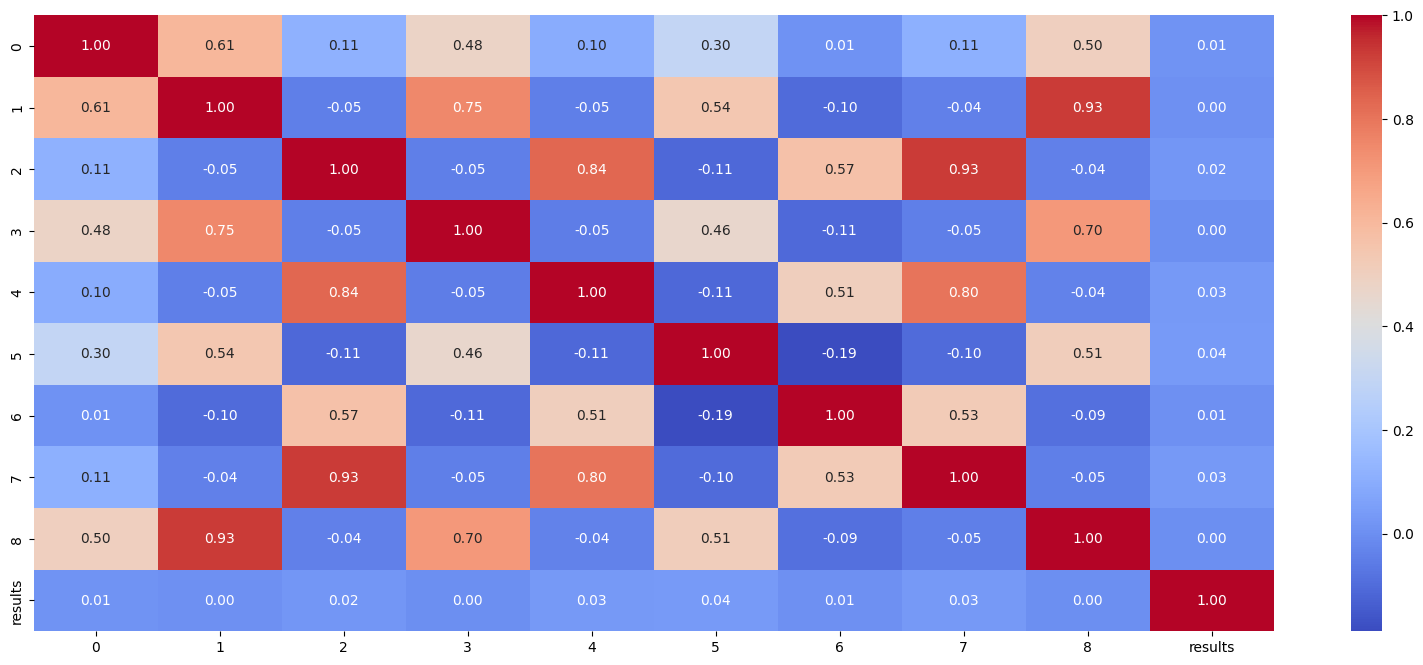

In [148]:
import seaborn as sns

def plot_correlation_matrix(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

corr_mat = pd.DataFrame(X_train)
corr_mat['results'] = y_train
plot_correlation_matrix(corr_mat)

## Model Selection and Training

In [149]:
from fonctions_tests import test_data, test_data_before_2023, get_accuracy_with_model

# Define the names of the classifications method
names = ["LogisticRegression",
         "NBayes",
         "LDA",
         "QDA",
         "KNN",
         "SVM linear",
         "SVM rbf",
         "SVM sigmoid",
         "RandomForest",
         "DecisionTree"]

# Define the classifiers
classifiers = [LogisticRegression(C=1e5),
               GaussianNB(),
               DA.LinearDiscriminantAnalysis(),
               DA.QuadraticDiscriminantAnalysis(),
               KNeighborsClassifier(n_neighbors=5),
               SVC(kernel='linear', C=1.0),
               SVC(kernel='rbf', gamma = 1e-4),
               SVC(kernel='sigmoid', gamma = 1e-4),
               RandomForestClassifier(),
               DecisionTreeClassifier()]

scores = []
scores_before = []

# Loop through all different classfication methods
for name, clf in zip(names, classifiers):
    
	clf.fit(X_train, y_train.values.ravel())
	y_pred = clf.predict(X_test)
	accuracy = accuracy_score(y_test, y_pred)
	scores.append(accuracy)

	print("\tAccuracy with", name, " : ", round(accuracy,3))

# print("test with all data before 2022, to predict the 2022 season")
# for name, clf in zip(names, classifiers):
#     accuracy = test_data_before_2023(data, model=clf)
#     scores_before.append(accuracy)
#     print("\tAccuracy with ", name, " : ", round(accuracy,3))

	Accuracy with LogisticRegression  :  0.397
	Accuracy with NBayes  :  0.442
	Accuracy with LDA  :  0.413
	Accuracy with QDA  :  0.45
	Accuracy with KNN  :  0.397
	Accuracy with SVM linear  :  0.411
	Accuracy with SVM rbf  :  0.479
	Accuracy with SVM sigmoid  :  0.429
	Accuracy with RandomForest  :  0.408
	Accuracy with DecisionTree  :  0.368


In [ ]:
X_axis = np.arange(len(names)) 
  
plt.bar(X_axis - 0.2, scores, 0.4, label = 'random data split') 
plt.bar(X_axis + 0.2, scores_before, 0.4, label = 'before 2022 split') 
  
plt.xticks(X_axis, names, rotation=45) 
plt.xlabel("models") 
plt.ylabel("accuracy") 
plt.title("Accuracy for every model") 
plt.legend()
plt.show() 


We can see that the bests models are : SVM linear, Logistic regression, and LDA. Therefore, we'll try to optimize the best one : SVM Linear.

Let's now find some hyperparameters for this model ! 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 2], 'kernel': ['linear']}

model = SVC()

grid_search = GridSearchCV(estimator = model, param_grid=param_grid, cv=5, scoring='accuracy',  n_jobs=-1, verbose=2)

data_for_grid = data.drop(columns=['date'])
train_df, val_df = train_test_split(data_for_grid, test_size=0.2, random_state=42)
X = val_df.drop(columns=['results'])
y = val_df[['results']]
# print(X)
print("start grid search")
grid_search.fit(X, y)

plt.plot(grid_search.cv_results_['mean_test_score'])


# print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)
